<a href="https://colab.research.google.com/github/SOF3/stat4609-project/blob/master/assignment-4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import datetime
import gc
import random
import time

import numpy
import pandas
import scipy
import matplotlib.pyplot as plt
import IPython.display as disp

class Progress:
    """Wrapper for IPython.display.ProgressBar with improved performance"""

    def __init__(self, total):
        self.bar = disp.ProgressBar(total)
        self.progress = 0
        self.last = 0
    def inc(self):
        self.progress += 1
        if time.monotonic_ns() - self.last > 1e8:
            self.bar.progress = self.progress
            self.bar.update()
            self.last = time.monotonic_ns()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_value, tb):
        self.bar.progress = self.progress
        self.bar.update()
        return False

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
!test -d dataset || unzip /content/drive/Shareddrives/'STAT4609 Netflix'/dataset.zip -d dataset

In [41]:
!cp /content/drive/Shareddrives/'STAT4609 Netflix'/preprocess-dataset /usr/local/bin
!chmod +x /usr/local/bin/preprocess-dataset
!test -f dataset/output.npy || (cd dataset && preprocess-dataset)

In [42]:
print("Loading data...")
data = numpy.load("dataset/output.npy")
data_size = data.shape[0]

data = data[data[:, 0] < 100000, :]

print("Counting users and movies")
user_count = numpy.max(data[:, 0]) + 1
movie_count = numpy.max(data[:, 1]) + 1

Loading data...
Counting users and movies


In [43]:
import numpy as np
np.set_printoptions(suppress=True)
print(data)

[[    0     0     3 ...   248     1     0]
 [    1     0     5 ...   132     4     0]
 [    2     0     4 ...   291     2     0]
 ...
 [29251  8196     1 ...   219     5     0]
 [22793  8196     4 ...   148     4     0]
 [76269  8196     2 ...    68     3     0]]


In [44]:
train = data[data[:, 6] == 0, :3].copy()
evaluation = data[data[:, 6] == 1, :3].copy()

del data
gc.collect()

print(f"Train/test split: {train.shape[0]}/{evaluation.shape[0]}")

Train/test split: 47676921/301977


Model:

In [45]:
from __future__ import print_function
import matplotlib.pyplot as plt

import torch

In [46]:
# Training settings
batch_size = 6400
test_batch_size = 1000
epochs = 5
lr = 1.0
gamma = 0.7
seed = 1
log_interval = 120
save_model = True
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [47]:
import torch.nn as nn
import torch.nn.functional as F

class Feedforward(torch.nn.Module):
    def __init__(self, user_size, movie_size, hidden_size):
        super(Feedforward, self).__init__()
        self.user_size = user_size
        self.movie_size = movie_size
        self.hidden_size  = hidden_size
        self.embedding_user = torch.nn.Embedding(num_embeddings=self.user_size, embedding_dim=self.hidden_size)
        self.embedding_movie = torch.nn.Embedding(num_embeddings=self.movie_size, embedding_dim=self.hidden_size)
        self.fc1 = torch.nn.Linear(self.hidden_size, 1)
        self.relu = torch.nn.ReLU()
    def forward(self, user_id, movie_id):
        user_embedding = self.embedding_user(user_id)
        movie_embedding = self.embedding_movie(movie_id)
        mul = torch.mul(user_embedding, movie_embedding)

        output = self.fc1(mul)
        return output

In [48]:
# Optimizer 
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


In [49]:
class GeneralizedMatrixFactorization2:
    def __init__(self, rank, epochs):
        # model define here
        self.model = Feedforward(user_count, movie_count, rank)
        self.model = self.model.to(device)
        self.criterion = nn.MSELoss()
        
        self.optimizer = optim.Adadelta(self.model.parameters(), lr=lr)
        self.scheduler = StepLR(self.optimizer, step_size=1, gamma=gamma)

        self.rank = rank
        self.epochs = epochs

    def train(self, ratings):
        data_loader = torch.utils.data.DataLoader(ratings, batch_size=64)
        self.model.train()
        history = []
        idx = 0
        with Progress(self.epochs * len(data_loader)) as progress:
            for epoch in range(self.epochs):
                try:
                    mse = 0
                    for batch_idx, (user, movie, target) in enumerate(data_loader):
                        user = user.to(device)
                        movie = movie.to(device)
                        target = target.to(device)
                        # set the gradients to zero to avoid unwanted gradient accumulation, see 
                        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
                        self.optimizer.zero_grad()
                        
                        # get model prediction
                        output = self.model(user, movie)
                        
                        # insert you own loss fucntion here, note that we implemented a log_softmax() in our model
                        loss = self.criterion(output.view(-1).float(), target.float())
    
                        mse += float(loss)
                        
                        # perform back propagation
                        loss.backward()
    
                        self.optimizer.step()
                        
                        # update parameters
                        progress.inc()
                except KeyboardInterrupt:
                    break
                
                history.append(np.sqrt(mse / len(data_loader)))
                print(f"Epoch {epoch}, mse = {mse / len(data_loader)}")

        plt.xlabel("Epochs")
        plt.ylabel("RMSE")
        plt.plot(np.arange(self.epochs), history)
        plt.show()

        return self

    def predict(self, user, movie):
        return float(self.model(torch.Tensor([user]).int().to(device),torch.Tensor([movie]).int().to(device)))

    def evaluate(self, evaluation):
        self.model.eval()
        se = 0
        for user, movie, rating in evaluation:
            err = self.predict(user, movie) - float(rating)
            se += err ** 2
        print("Test RMSE: {}".format(np.sqrt(se/len(evaluation))))

In [50]:
import torch.nn as nn
import torch.nn.functional as F

class Feedforward2(torch.nn.Module):
    def __init__(self, user_size, movie_size, hidden_size):
        super(Feedforward2, self).__init__()
        self.user_size = user_size
        self.movie_size = movie_size
        self.hidden_size  = hidden_size
        self.embedding_user = torch.nn.Embedding(num_embeddings=self.user_size, embedding_dim=self.hidden_size)
        self.embedding_movie = torch.nn.Embedding(num_embeddings=self.movie_size, embedding_dim=self.hidden_size)
        self.fc1 = torch.nn.Linear(self.hidden_size, 1)
    def forward(self, user_id, movie_id):
        user_embedding = self.embedding_user(user_id)
        movie_embedding = self.embedding_movie(movie_id)
        mul = torch.mul(user_embedding, movie_embedding)

        output = self.fc1(mul)
        return output

In [51]:
class GeneralizedMatrixFactorization2:
    def __init__(self, rank, learning_rate, gamma, batch_size, training_time):
        # model define here
        self.model = Feedforward2(user_count, movie_count, rank)
        self.model = self.model.to(device)
        self.criterion = nn.MSELoss()
        
        self.optimizer = optim.Adadelta(self.model.parameters(), lr=learning_rate, weight_decay=0.0)
        self.scheduler = StepLR(self.optimizer, step_size=1, gamma=gamma)

        self.rank = rank
        self.batch_size = batch_size

        self.training_time = training_time

    def train(self, ratings):
        data_loader = torch.utils.data.DataLoader(ratings, batch_size=self.batch_size)
        self.model.train()
        history = []
        idx = 0
        epoch = 0
        with Progress(100 * len(data_loader)) as progress:
            start_time = time.time()
            while time.time() - start_time < self.training_time:
                try:
                    mse = 0
                    for batch_idx, batch in enumerate(data_loader):
                        user = batch[:, 0]
                        movie = batch[:, 1]
                        target = batch[:, 2]
                        user = user.to(device)
                        movie = movie.to(device)
                        target = target.to(device)
                        # set the gradients to zero to avoid unwanted gradient accumulation, see 
                        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
                        self.optimizer.zero_grad()
                        
                        # get model prediction
                        output = self.model(user, movie)
                        
                        # insert you own loss fucntion here, note that we implemented a log_softmax() in our model
                        loss = self.criterion(output.view(-1).float(), target.float())
    
                        mse += float(loss)
                        
                        # perform back propagation
                        loss.backward()
    
                        self.optimizer.step()
                        
                        # update parameters
                        progress.inc()
                except KeyboardInterrupt:
                    break
                finally:
                    history.append(np.sqrt(mse / len(data_loader)))
                    print(f"Epoch {epoch} ({(time.time() - start_time) / 60} min), mse = {mse / len(data_loader)}")
                    epoch += 1

        plt.xlabel("Epochs")
        plt.ylabel("RMSE")
        plt.plot(np.arange(epoch), history)
        plt.show()

        return self

    def predict(self, user, movie):
        return float(self.model(torch.Tensor([user]).int().to(device),torch.Tensor([movie]).int().to(device)))

    def evaluate(self, evaluation):
        self.model.eval()
        se = 0
        for user, movie, rating in evaluation:
            err = self.predict(user, movie) - float(rating)
            se += err ** 2
        print("Test RMSE: {}".format(np.sqrt(se/len(evaluation))))


[=====                                                       ] 6552/72800

Epoch 0 (3.730263078212738 min), mse = 5.6145525851419995
Epoch 1 (7.496627128124237 min), mse = 1.1794887732837227
Epoch 2 (11.2935755610466 min), mse = 1.1638430482247373
Epoch 3 (15.126986002922058 min), mse = 1.1638430155568071
Epoch 4 (18.902264416217804 min), mse = 1.1638429751926727
Epoch 5 (22.69548547665278 min), mse = 1.1638429273779576
Epoch 6 (26.48063761393229 min), mse = 1.163842882838223
Epoch 7 (30.2784628311793 min), mse = 1.163842836006002
Epoch 8 (34.062812407811485 min), mse = 1.1638427962968638


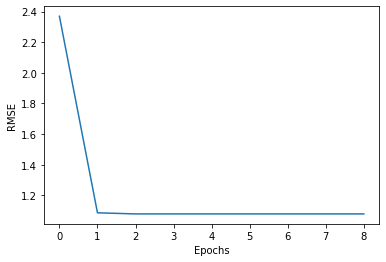

Test RMSE: 1.0861063132198032


In [52]:
g = GeneralizedMatrixFactorization2(100, 1.0, 0.7, 65535, 2000)
g.train(train).evaluate(evaluation)

[=====                                                       ] 6552/72800

Epoch 0 (3.993168214956919 min), mse = 5.710504464723251
Epoch 1 (7.993724397818247 min), mse = 1.1817975305430182
Epoch 2 (12.007093171278635 min), mse = 1.1649126354809647
Epoch 3 (15.969143438339234 min), mse = 1.1649125120142003
Epoch 4 (19.87429452339808 min), mse = 1.164912377985624
Epoch 5 (23.78632361094157 min), mse = 1.1649122424014322
Epoch 6 (27.735622298717498 min), mse = 1.1649121031328873
Epoch 7 (31.66898326476415 min), mse = 1.1649119670574481
Epoch 8 (35.587493065992994 min), mse = 1.1649118327013739


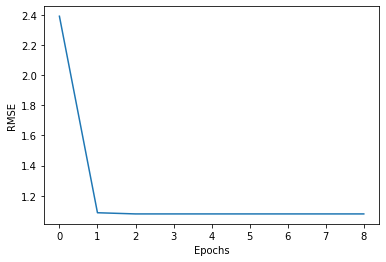

Test RMSE: 1.0869594688018298


In [53]:
g = GeneralizedMatrixFactorization2(300, 1.0, 0.7, 65535, 2000)
g.train(train).evaluate(evaluation)

[=====                                                       ] 6552/72800

Epoch 0 (3.7884937286376954 min), mse = 11.916761860742675
Epoch 1 (7.5837215741475426 min), mse = 8.412799968824281
Epoch 2 (11.400402887662251 min), mse = 5.199209842053088
Epoch 3 (15.232778318723042 min), mse = 2.985623850436001
Epoch 4 (19.055240015188854 min), mse = 1.8149193662863512
Epoch 5 (22.876783843835195 min), mse = 1.3550932641540254
Epoch 6 (26.71820987065633 min), mse = 1.2140063296307575
Epoch 7 (30.513678809007008 min), mse = 1.1748250749084976
Epoch 8 (34.28911795218786 min), mse = 1.1653551310300827


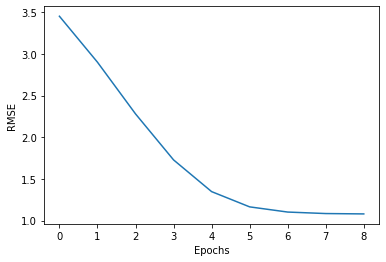

Test RMSE: 1.0881613129646628


In [54]:
g = GeneralizedMatrixFactorization2(100, 0.1, 0.9, 65535, 2000)
g.train(train).evaluate(evaluation)

[=====                                                       ] 104760/1164000

Epoch 0 (3.9307451486587524 min), mse = 1.4643752879600753
Epoch 1 (7.933116865158081 min), mse = 1.1637031799175894
Epoch 2 (11.894106205304464 min), mse = 1.1636992829208521
Epoch 3 (15.860867126782734 min), mse = 1.1636953604026758
Epoch 4 (19.837525296211243 min), mse = 1.163691402336781
Epoch 5 (23.78875788450241 min), mse = 1.1636874283097454
Epoch 6 (27.716263401508332 min), mse = 1.1636834287663915
Epoch 7 (31.686163957913717 min), mse = 1.1636793919752553
Epoch 8 (35.659867294629414 min), mse = 1.1636753165793583


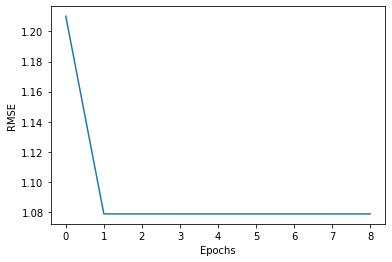

Test RMSE: 1.0897713142694387


In [55]:
g = GeneralizedMatrixFactorization2(100, 1.0, 0.7, 4096, 2000)
g.train(train).evaluate(evaluation)

[====                                                        ] 368/4600

Epoch 0 (4.673669950167338 min), mse = 13.179858497951342
Epoch 1 (8.936037731170654 min), mse = 11.899996052617611
Epoch 2 (13.177859675884246 min), mse = 10.665002408234969
Epoch 3 (17.38041772842407 min), mse = 9.437212031820547
Epoch 4 (21.565734283129373 min), mse = 8.249012553173563
Epoch 5 (25.756593600908914 min), mse = 7.125764888265858
Epoch 6 (29.995626497268677 min), mse = 6.086495492769324
Epoch 7 (34.198833203315736 min), mse = 5.144671284634134


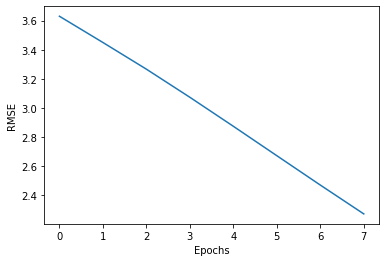

Test RMSE: 2.2311285276387465


In [56]:
g = GeneralizedMatrixFactorization2(100, 1.0, 0.7, 1048576, 2000)
g.train(train).evaluate(evaluation)